# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. Using this network, we will be generated new digits!

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes fake data to pass to the discriminator. The discriminator also sees real data and predicts if the data it's received is real or fake. The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real data. And the discriminator is trained to figure out which data is real and which is fake. What ends up happening is that the generator learns to make data that is indistiguishable from real data to the discriminator.

## Generator network

Here we'll build the generator network. We will use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

#### Leaky ReLU
Typically, a parameter `alpha` sets the magnitude of the output for negative values. So, the output for negative input (`x`) values is `alpha*x`, and the output for positive `x` is `x`:
$$
f(x) = max(\alpha * x, x)
$$
For implementing the leaky relu, you could use the following resource https://keras.io/layers/advanced-activations/

#### Tanh Output
The generator has been found to perform the best with $tanh$ for the generator output. This means that we'll have to rescale the MNIST images to be between -1 and 1, instead of the usual 0 and 1 range. 

## Discriminator

The discriminator network is almost exactly the same as the generator network, except that we're using a sigmoid output layer.

## Build network

Now we're are going to build the generator and discrimator networks.

We'll create the generator, `generator(input_z, input_size)`. This builds the generator with the appropriate input and output sizes.

Then the discriminators. We'll build two of them, one for real data and one for fake data. Since we want the weights to be the same for both real and fake data, we need to reuse the variables. For the fake data, we're getting it from the generator as `g_model`. So the real data discriminator is `discriminator(input_real)` while the fake discriminator is `discriminator(g_model, reuse=True)`.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
from tqdm import tqdm
from __future__ import print_function, division
import matplotlib.pyplot as plt
import sys
import numpy as np

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras import initializers
from keras.optimizers import Adam

from keras import backend as K 

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Load MNIST data
def load_data(path='mnist.npz'):
    """Loads the MNIST dataset.
    # Arguments
        path: path where to cache the dataset locally
            (relative to ~/.keras/datasets).
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    path = "mnist.npz"
    f = np.load(path)
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)

In [3]:
# Generator
def build_generator(latent_dim):
    # Make sure to use a tanh activation at the last layer and compile the model before returning it
    # For upsampling the image, you could use UpSampling2D function from Keras library. 
    # Use adam optimizer with: adam = Adam(0.0002, 0.5)
    
    # Prepare model for inputs of shape latent_dim
    generator_input = Input(shape=(latent_dim,))
    
    # Build model to mimic CIFAR10 example from textbook (with correct sizes for MNINST image - 28x28x1)
    x = Dense(32 * 14 * 14)(generator_input)
    
    # Reshape to 14x14x32
    x = LeakyReLU()(x)
    x = Reshape((14, 14, 32))(x)
    
    x = Conv2D(64, 3, padding='same')(x)
    x = LeakyReLU()(x)
    
    # Upsample to 28x28 (MNIST image resolution)
    x = Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(64, 3, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(64, 3, padding='same')(x)
    x = LeakyReLU()(x)
    
    # Decrease to proper image size (28x28x1)    
    x = Conv2D(1, 3, activation='tanh', padding='same')(x)
    
    generator = Model(generator_input, x)
    generator.summary()
    
    adam = Adam(0.0002, 0.5)    
    # Compile model
    generator.compile(optimizer=adam, loss='binary_crossentropy')
    
    return generator

In [5]:
# Discriminator
def build_discriminator(img_shape):
    # Make sure to use a sigmoid at the last layer and compile the model before returning it
    # Use adam optimizer with adam = Adam(0.0002, 0.5)
    img_rows, img_cols, channels = img_shape
    
    # Accept inputs of 28x28x1
    discriminator_input = Input(shape=(img_rows, img_cols, channels))
    
    x = Conv2D(32, 4)(discriminator_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(32, 4, strides=1)(x)
    x = LeakyReLU()(x)
    x = Conv2D(32, 4, strides=2)(x)
    x = LeakyReLU()(x)
    x = Conv2D(32, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    
    x = Dropout(0.4)(x) # May need to tweak this
    
    x = Dense(1, activation='sigmoid')(x)
    
    discriminator = Model(discriminator_input, x)
    discriminator.summary()
    
    adam = Adam(0.0002, 0.5)
    
    # Compile model
    discriminator.compile(optimizer=adam, loss='binary_crossentropy')
    
    return discriminator

In [7]:
# Now that we've built the disriminator and generator, lets combine the two for the full end to end system.
# This is where we are calculating D(G(z))!
# We will set up a Model object to train the generator to fool the discriminator. We need to turn of
# weight updates for the discriminator, create an Input object for the generator with the right
# dimension, run that through the generator, and run the output of the generator through the discriminator. 
# You should compile this new Model object.
def build_gan(discriminator, generator, latent_dim):
    
    discriminator.trainable = False
    
    gan_input = Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    
    gan = Model(gan_input, gan_output)
    
    adam = Adam(0.0002, 0.5)
    
    gan.compile(optimizer=adam, loss='binary_crossentropy')
    
    return gan

In [8]:
# Parameters for our mnist dataset. 
img_rows = 28
img_cols = 28
channels = 1
# Feel free to change the order of channels, rows, and cols if you go ahead with a different order 
# in your discriminator and generator. 
# img_shape = (channels, img_rows, img_cols)
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

In [9]:
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        # Reshape image
        image = generatedImages[i].reshape(28,28)
        plt.imshow(image, interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/dcgan_generated_image_epoch_DeVore_final_%d.png' % epoch)

In [10]:
# Build and compile the discriminator
discriminator = build_discriminator(img_shape)

# Build and compile the generator
generator = build_generator(latent_dim)

# Build and compile the combined network
gan = build_gan(discriminator, generator, latent_dim)

epochs = 10
batch_size = 32
save_interval = 50

# Load MNIST data and rescale -1 to 1
(X_train, y_train), (X_test, y_test) = load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]
# Reshape images
X_train = X_train.reshape((X_train.shape[0],) + img_shape)

# Store losses
dloss_vec = []
gloss_vec = []

batchCount = X_train.shape[0] / batch_size
for e in range(1, epochs+1):
    start = 0
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for c in tqdm(range(int(batchCount))):
        
        # Get a random sample from real images, and from random noise
        # Sample from normal distribution, size should be 128x100
        noise = np.random.normal(size=(batch_size, latent_dim))
        # Keep track on position in training set, sample next 128 images
        stop = start + batch_size
        imageBatch = X_train[start:stop]
        start += batch_size

        # Generate fake MNIST images, from noise
        generatedImages = generator.predict(noise)
        
        # Lets train the discriminator first. 
        # We will concatenate the real images and fake images into a variable X
        X = np.concatenate([generatedImages, imageBatch])

        # Create the labels for fake and real data, composed of 0s and 1s
        # Note that ones are for fake images, and zeros are for real images
        yDis = np.concatenate([np.ones((batch_size,1)), np.zeros((batch_size,1))])
        # Consider adding noise to labels
        yDis += 0.05 * np.random.random(yDis.shape)

        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        # Now lets train the generator
        # Generate batch_size sized random noise 
        noise = np.random.normal(size=(batch_size, latent_dim))
        
        # Generate the labels for the generator
        # These labels should all be for 'real' images
        yGen = np.zeros((batch_size,1))
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)
        
    # Try printing loss and saving weights after each epoch
    gan.save_weights('gan.h5')
    print('discriminator loss:', dloss)
    print('adversarial loss:', gloss)
    dloss_vec.append(dloss)
    gloss_vec.append(gloss)
        
    if e == 1 or e % 5 == 0:
        # Save after certain epochs
        plotGeneratedImages(e, generator)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        544       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        16416     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        16416     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 10, 10, 32)        0         
__________

  0%|          | 0/1875 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


100%|██████████| 1875/1875 [01:32<00:00, 20.25it/s]


discriminator loss: 0.60331225
adversarial loss: 0.86873764


  0%|          | 2/1875 [00:00<02:00, 15.50it/s]

--------------- Epoch 2 ---------------


  0%|          | 3/1875 [00:00<01:27, 21.40it/s]

discriminator loss: 0.5174006
adversarial loss: 1.0115827
--------------- Epoch 3 ---------------


  0%|          | 3/1875 [00:00<01:28, 21.11it/s]

discriminator loss: 0.4913813
adversarial loss: 1.0878357
--------------- Epoch 4 ---------------


  0%|          | 3/1875 [00:00<01:29, 20.89it/s]

discriminator loss: 0.5663186
adversarial loss: 0.9296609
--------------- Epoch 5 ---------------


100%|██████████| 1875/1875 [01:30<00:00, 20.77it/s]


discriminator loss: 0.5594814
adversarial loss: 0.98968416


  0%|          | 2/1875 [00:00<01:58, 15.85it/s]

--------------- Epoch 6 ---------------


  0%|          | 3/1875 [00:00<01:29, 20.91it/s]

discriminator loss: 0.5501053
adversarial loss: 0.9014426
--------------- Epoch 7 ---------------


  0%|          | 3/1875 [00:00<01:29, 20.85it/s]

discriminator loss: 0.54522526
adversarial loss: 0.86188567
--------------- Epoch 8 ---------------


  0%|          | 3/1875 [00:00<01:28, 21.25it/s]

discriminator loss: 0.54309314
adversarial loss: 0.9855986
--------------- Epoch 9 ---------------


  0%|          | 3/1875 [00:00<01:29, 20.90it/s]

discriminator loss: 0.593326
adversarial loss: 0.867559
--------------- Epoch 10 ---------------


100%|██████████| 1875/1875 [01:29<00:00, 20.86it/s]


discriminator loss: 0.5853712
adversarial loss: 0.97934216


## Results
Please embed some of the images you have generated and turn them in with your notebook!

Before we post some images, let's take a look at how the loss functions changed over the 10 epochs. Since there are two loss functions, the model won't converge to a single minimum, rather the two loss functions will achieve a balance where neither one is changing drastically between each epoch.

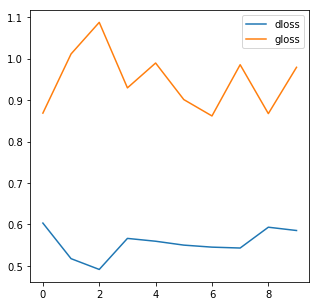

In [12]:
plt.figure(figsize=(5,5))
plt.plot(dloss_vec)
plt.plot(gloss_vec)
plt.legend(['dloss','gloss'])
plt.show()

Both loss functions seem stable, and more or less at equilibrium, which is the desired behavior for a GAN.

### Generator Images After First Epoch

Let's take a look at a sample of generated images after the 1st epoch:

<img src="dcgan_generated_image_epoch_DeVore_final_1.png",width=800,height=800>

Even after just a single epoch, many of the generated images resemble actual numbers. That being said, there is plenty of room for improvement.

### Generator Images After Tenth Epoch

Let's see how the fully trained generator compares by looking at the images generated after the 10th and final epoch.

<img src="dcgan_generated_image_epoch_DeVore_final_10.png",width=800,height=800>

These look much better, and are nearly indistinguishable from handwritten digits. The results are particularly impressive since the network was trained using only 10 iterations of the training set, and in just over 10 minutes.

## Conceptual Overview



The structure of the GAN is different from anything we've seen so far. Rather than a single network, the GAN is actually composed of two networks. These networks, known as the generator and discriminator, have an adversarial relationship with one another (hence the name). In this exercise, both the generator and discriminator were convolutional neural networks, although this doesn't have to be the case. The generators job is to fool the discriminator by producing images that are indistinguishable from real images from a training set, and the discriminators job is to not be fooled by the generators attempts at forgery.

One other major difference is that LeakyRelu activation functions are used for both networks. Sparsity is often your friend when it comes to deep learning, but not for GANs. Using the LeakyRelu allows for small negative outputs, as opposed to a standard Relu which would output zeros as a response to any negative input.

The form of the generator network is rather unique. The input consists of a random sample of a predetermined size from a Gaussian distribution. This input is fed to a dense layer whose output is reshaped to a square tensor half the size of the output image (with some number of filters, in our case 32). This feature map tensor is passed through a convolution layer and then upsampled to the output image size. After several convolutions with varying numbers of filters (either 32 or 64 here), an image is produced as output from the generator with the proper size (in our case it's a 28x28x1). The final activation function is a hyperbolic tangent (tanh), which maps all values from -1 to 1.

For the discriminator, the network structure looks much more familiar. The input is an image (28x28x1 here), and after several strided convolutions and a dropout layer, a final dense layer with a single node and sigmoid activation function outputs a probability of the image it just processed being real.

The structure of the actual GAN is rather simple. The input is random noise (the input to the generator), and the output is the prediction made by the discriminator, which has been fed the output from the generator which has been fed the random noise input. Within the GAN, the discriminator is not trainable (this is very important!).

The GAN training consists of two phases, which are repeated for each batch of images within each epoch. First, images are created by the generator and labeled as 'fake'. These are combined with images from the training set, which are labeled as 'real'. The discriminator is trained using these images. First, the fake images are just random noise, but they get better over time (as the generator learns how to produce more convincing images), which makes the discriminator better at spotting fake images. Second, another batch of images is created by the generator, except these are labeled as 'real' (to try and fool the discriminator). These images are fed to the discriminator within the GAN (recall that it's weights are frozen), and the weights of the generator are updated so that it is better able to fool the discriminator over time.

During training, dual loss functions are monitored (from the discriminator and the GAN, which is really just the generator). There is no convergence here, rather the loss functions come to an equilibrium with one another. This state represents the generator producing images that are so convincing that the discriminator can't tell if they are real or not, and it settles to an accuracy of roughly 50% (it is no better than random guesses as to the authenticity of an image).

Overall, I was really impressed with the generators ability to create convincing handwritten digit images after only 10 epochs of training. The biggest challenges encountered were that I made the network too complex at first (I modeled it after an example in the textbook which was used to generate more detailed color images). After some debugging I found that the model was overfitting after only 10 iterations, during the first epoch. Scaling back the number of filters created in the convolution layers helped immensely, and soon I was generating digits. The other challenge was that my generated numbers often had dark borders around the edges of the image. The numbers themselves looked good, but the border artifacts were distracting. Careful tuning of the filter sizes and stride lengths helped eliminate this phenomenon. Admittedly, this was an extremely simple implementation of a GAN, and they are notoriously hard to train. Still, these results were encouraging and give me the confidence to try a harder problem (like color images!).